# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 28.01.2022


### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, (1/\sigma^2)I)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а **можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество.** В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from random import seed, choice
from random import choices
seed(274)

sns.set(style='darkgrid')

### __Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from math import pi, cos

In [ ]:
from catboost import CatBoostClassifier
import optuna

optuna.logging.disable_propagation()
optuna.logging.disable_default_handler()

In [ ]:
from scipy.sparse.linalg.dsolve.linsolve import use_solver

class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier='logreg', iters=100):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.PCA = PCA(n_components=self.new_dim)
        if classifier == 'logreg':
            self.classifier = LogisticRegression(max_iter=iters)
            # , C=40,
            # solver='sag', 
            # multi_class='auto',
            # verbose=1
        elif classifier == 'svm':
            self.classifier = SVC(kernel='linear', tol=1e-2)
        else:
            raise 'UnknownClassiferError'
        # weights
        self.ws = None
        self.bs = None
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        # Principal Component Analysis (PCA)
        if not self.use_PCA:
            self.new_dim = X.shape[1]
            X_reduced = X.copy() / 255.
        else:
            X_reduced = self.PCA.fit_transform(X / 255.)
        # Random Fourier Features (RFF)
        sigma2 = np.median([np.linalg.norm(choice(X_reduced) - choice(X_reduced))**2 for i in range(1000000)])
        self.ws = np.random.multivariate_normal(np.zeros(self.new_dim), (1 / sigma2) * np.eye(self.new_dim), size=self.n_features)
        self.bs = np.random.uniform(-pi, pi, size=self.n_features)
        w_matrix = X_reduced @ np.transpose(self.ws)
        b_matrix = self.bs * np.ones(X_reduced.shape[0]).reshape(-1, 1)
        X_modified = np.cos(w_matrix + b_matrix)
        # Classification
        print('Fitting started!')
        self.classifier.fit(X_modified, y)
        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        X_reduced = self.PCA.transform(X / 255.) if self.use_PCA else (X.copy() / 255.)
        X_modified = np.cos(X_reduced @ np.transpose(self.ws) + self.bs * np.ones(X_reduced.shape[0]).reshape(-1, 1))
        return self.classifier.predict_proba(X_modified)
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X_reduced = self.PCA.transform(X / 255.) if self.use_PCA else (X.copy() / 255.)
        X_modified = np.cos(X_reduced @ np.transpose(self.ws) + self.bs * np.ones(X_reduced.shape[0]).reshape(-1, 1))
        print('Prediction started!')
        return self.classifier.predict(X_modified)

In [ ]:
import keras
from keras.datasets import fashion_mnist

(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

In [ ]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

2

#### Запуски с разными параметрами

Нужного качества без PCA уже научились достигать! Теперь включим применение метода главных компонент:

In [ ]:
%%time
logreg_rff_model = RFFPipeline(classifier='logreg', new_dim=50, n_features=1000)
logreg_rff_model.fit(x_train, y_train)
y_pred = logreg_rff_model.predict(x_test)
print('Accuracy_score on test data Fashion MNIST (LogReg default):  ', accuracy_score(y_pred, y_test))

Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Prediction started!
Accuracy_score on test data Fashion MNIST (LogReg default):   0.8542
CPU times: user 55 s, sys: 17.4 s, total: 1min 12s
Wall time: 45 s


Интересно, через сколько эпох метод будет сходиться? (поставим max_iter=10000)

При разном кол-ве выходных параметров:

In [ ]:
logreg_rff_model = RFFPipeline(classifier='logreg', use_PCA=False, n_features=100)
logreg_rff_model.fit(x_train, y_train)
y_pred = logreg_rff_model.predict(x_test)
print('Accuracy_score on test data Fashion MNIST:  ', accuracy_score(y_pred, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
convergence after 180 epochs took 58 seconds
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.0s finished
Accuracy_score on test data Fahion MNIST:   0.8116


In [ ]:
logreg_rff_model = RFFPipeline(classifier='logreg', use_PCA=False, n_features=300)
logreg_rff_model.fit(x_train, y_train)
y_pred = logreg_rff_model.predict(x_test)
print('Accuracy_score on test data Fashion MNIST:  ', accuracy_score(y_pred, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  9.8min finished


Accuracy_score on test data Fahion MNIST:   0.8458


In [ ]:
logreg_rff_model = RFFPipeline(classifier='logreg', new_dim=50, n_features=500)
logreg_rff_model.fit(x_train, y_train)
y_pred = logreg_rff_model.predict(x_test)
print('Accuracy_score on test data Fashion MNIST (LogReg default):  ', accuracy_score(y_pred, y_test))

Fitting started!


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 1992 epochs took 2800 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 46.7min finished


Prediction started!
Accuracy_score on test data Fashion MNIST (LogReg default):   0.8737


In [ ]:
logreg_rff_model = RFFPipeline(classifier='logreg', new_dim=50, n_features=1000)
logreg_rff_model.fit(x_train, y_train)
y_pred = logreg_rff_model.predict(x_test)
print('Accuracy_score on test data Fashion MNIST (LogReg default):  ', accuracy_score(y_pred, y_test))

Fitting started!


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 3028 epochs took 8252 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 137.5min finished


Prediction started!
Accuracy_score on test data Fashion MNIST (LogReg default):   0.8746


Качество класс! Только работает долго.. SVM-вариант:

In [ ]:
%%time
svm_rff_model = RFFPipeline(classifier='svm', new_dim=50, n_features=1000)
svm_rff_model.fit(x_train, y_train)
y_pred = svm_rff_model.predict(x_test)
print('Accuracy_score on test data Fashion MNIST (SVM 1000feat):  ', accuracy_score(y_pred, y_test))

Fitting started!
Prediction started!
Accuracy_score on test data Fashion MNIST (SVM 1000feat):   0.863
CPU times: user 1min 30s, sys: 4.28 s, total: 1min 35s
Wall time: 1min 30s


На SVM требуемое качество тоже получено.

Но учатся модели в colab на одном ядре и с ограниченным объемом cpu до сходимости вечность, сократим обучающую выборку в три раза до 20000 картинок (как рекомендовано ниже).

In [ ]:
nums = choices(range(60000), k=20000)
x_train = x_train[nums]
y_train = y_train[nums]

### __Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

#### 1) линейный SVM на исходных признаках

In [ ]:
%%time
svm_linear_model = make_pipeline(StandardScaler(), SVC(kernel='linear', verbose=True))
svm_linear_model.fit(x_train, y_train)
y_pred = svm_linear_model.predict(x_test)
print('Accuracy_score on test (Linear SVM with default features):  ', accuracy_score(y_pred, y_test))

[LibSVM]Accuracy_score on test (Linear SVM with default features):   0.8024
CPU times: user 1min 42s, sys: 411 ms, total: 1min 42s
Wall time: 1min 42s


#### 2) Linear SVM на случайных признаках

 (еще раз, чтобы на тех же данных)

In [ ]:
%%time
svm_rff_model = make_pipeline(StandardScaler(), RFFPipeline(classifier='svm', new_dim=50, n_features=1000))
svm_rff_model.fit(x_train, y_train)
y_pred = svm_rff_model.predict(x_test)
print('Accuracy_score on short test (SVM 1000feat):  ', accuracy_score(y_pred, y_test))

Fitting started!
Prediction started!
Accuracy_score on short test (SVM 1000feat):   0.8603
CPU times: user 1min 21s, sys: 3.27 s, total: 1min 24s
Wall time: 1min 20s


#### 2) Ядровой SVM

In [ ]:
%%time
svm_model = make_pipeline(StandardScaler(), SVC(kernel='sigmoid', verbose=True))
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print('Accuracy_score on test (SVM with sigmoid kernel):  ', accuracy_score(y_pred, y_test))

[LibSVM]Accuracy_score on test (SVM with sigmoid kernel):   0.7254
CPU times: user 1min 8s, sys: 83.7 ms, total: 1min 8s
Wall time: 1min 8s


In [ ]:
%%time
svm_model = make_pipeline(StandardScaler(), SVC(kernel='poly', verbose=True))
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print('Accuracy_score on test (SVM with polynom kernel):  ', accuracy_score(y_pred, y_test))

[LibSVM]Accuracy_score on test (SVM with polynom kernal):   0.8455
CPU times: user 1min 48s, sys: 190 ms, total: 1min 48s
Wall time: 1min 52s


In [ ]:
%%time
svm_rbf_model = make_pipeline(StandardScaler(), SVC(kernel='rbf', verbose=True))
svm_rbf_model.fit(x_train, y_train)
y_pred = svm_rbf_model.predict(x_test)
print('Accuracy_score on test (SVM with gaussian kernel):  ', accuracy_score(y_pred, y_test))

[LibSVM]Accuracy_score on test (SVM with gaussian kernel):   0.8636
CPU times: user 1min 48s, sys: 143 ms, total: 1min 48s
Wall time: 1min 48s


#### Catboost & Optuna params

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

In [ ]:
class CatboostPCA(BaseEstimator, TransformerMixin):
    def __init__(self, new_dim=50, use_PCA=True, lr=0.1, n_estimators=10):
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.PCA = PCA(n_components=self.new_dim)
        self.classifier = CatBoostClassifier(iterations=n_estimators,
                                             learning_rate=lr,
                                             logging_level="Silent")

    def fit(self, X, y):
        # Principal Component Analysis (PCA)
        if not self.use_PCA:
            self.new_dim = X.shape[1]
            X_reduced = X.copy() / 255.
        else:
            X_reduced = self.PCA.fit_transform(X / 255.)
        # Classification
        self.classifier.fit(X_reduced, y)
        return self

    def predict_proba(self, X):
        X_reduced = self.PCA.transform(X / 255.) if self.use_PCA else (X.copy() / 255.)
        return self.classifier.predict_proba(X_reduced)
        
    def predict(self, X):
        X_reduced = self.PCA.transform(X / 255.) if self.use_PCA else (X.copy() / 255.)
        return self.classifier.predict(X_reduced)

In [ ]:
%%time

def pipeline(trial):
  nest = trial.suggest_int('n_estimators', 5, 200)
  lr = trial.suggest_uniform('learning_rate', 0.001, 1)

  catboost = CatboostPCA(new_dim=100, n_estimators=nest, lr=lr)
  catboost = catboost.fit(x_train, y_train)
  y_pred = catboost.predict(x_test)
  acc =  accuracy_score(y_pred, y_test)
  # print(acc)
  return - acc


study = optuna.create_study()
study.optimize(pipeline, n_trials=25)

CPU times: user 31min 25s, sys: 37.7 s, total: 32min 2s
Wall time: 16min 30s


In [ ]:
print('best catboost accuracy:', -study.best_value)

best catboost accuracy: 0.8449


In [ ]:
print('best catboost accuracy:', -study.best_value)

In [ ]:
study.best_params

{'learning_rate': 0.18701143891070177, 'n_estimators': 191}

In [ ]:
%%time

catboost = CatboostPCA(new_dim=100, n_estimators=191, lr=0.1870114389)
catboost = catboost.fit(x_train, y_train)
y_pred = catboost.predict(x_test)
print(accuracy_score(y_pred, y_test))

0.8451
CPU times: user 1min 42s, sys: 1.46 s, total: 1min 44s
Wall time: 53.9 s


#### Выводы

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

**Выводы**: Переход к случайным признакам позволяет существенно улучшить качество без значительного увеличения времени работы (на примере линейного SVM, ***на трети обучающей выборки*** поднялось с 0.80 до 0.85). 

Встроенный ядровой SVM может показать еще лучшие результаты по точности при правильном выборе ядра. В нашем случае гауссовы ядра rbf дали качество еще выше. Sigmoid - самый быстрый, но точность просела, полиномиальное ядро показало себя по времени и качеству хорошо, но не лидирует.

Метод градиентного бустинга после подбора параметров (занимает опр. время) показал себя на сопоставимом уровне (но хуже rbf swm по качеству) при параметре кол-ва моделей в лесу - 191 и без доп. ограничений на глубину. CPU time >> Wall time практически на минуту - потребовалось время на ожидание процессов работы с памятью.

Итого - да, случайные признаки - действительно полезная методика.



### __Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

#### Use_PCA test для RFF SVM

In [ ]:
%%time
svm_rff_model = make_pipeline(StandardScaler(), RFFPipeline(classifier='svm'))
svm_rff_model.fit(x_train, y_train)
y_pred = svm_rff_model.predict(x_test)
print('Accuracy_score on short test (SVM 1000feat):  ', accuracy_score(y_pred, y_test))

Fitting started!
Prediction started!
Accuracy_score on short test (SVM 1000feat):   0.8548
CPU times: user 1min 22s, sys: 3.07 s, total: 1min 25s
Wall time: 1min 21s


In [ ]:
%%time
svm_rff_model = make_pipeline(StandardScaler(), RFFPipeline(classifier='svm', use_PCA=False))
svm_rff_model.fit(x_train, y_train)
y_pred = svm_rff_model.predict(x_test)
print('Accuracy_score on short test (RFF SVM No PCA):  ', accuracy_score(y_pred, y_test))

Fitting started!
Prediction started!
Accuracy_score on short test (RFF SVM No PCA):   0.8339
CPU times: user 1min 23s, sys: 507 ms, total: 1min 24s
Wall time: 1min 22s


#### Use_PCA test для  Catboost

In [ ]:
%%time

catboost = CatboostPCA(new_dim=100, n_estimators=191, lr=0.1870114389)
catboost = catboost.fit(x_train, y_train)
y_pred = catboost.predict(x_test)
print('Accuracy of Catboost with PCA_100:  ', accuracy_score(y_pred, y_test))

Accuracy of Catboost with PCA_100:   0.8452
CPU times: user 1min 42s, sys: 2.13 s, total: 1min 44s
Wall time: 1min 8s


In [ ]:
%%time

catboost = CatboostPCA(use_PCA=False, n_estimators=191, lr=0.1870114389)
catboost = catboost.fit(x_train, y_train)
y_pred = catboost.predict(x_test)
print('Accuracy of Catboost using same params without PCA:  ', accuracy_score(y_pred, y_test))

Accuracy of Catboost using same params without PCA:   0.8574
CPU times: user 12min 49s, sys: 833 ms, total: 12min 50s
Wall time: 6min 35s


__Вывод про PCA__ Тестирование двух моделей SVM на одинаковых исходных параметрах показывает, что предварительное понижение размерности, действительно, помогает улучшить качество. В случае же Catboost качество возросло (не так уж и сильно) вместе с увеличением времени работы более, чем в 5 раз, без понижения размерности. Вывод - полезно его делать!

#### n_features в RFF

Число случайных признаков. В первой части мы уже обучили несколько logreg моделей с разным параметром n_features до сходимости - это было очень долго. Но мы смогли пронаблюдать, что с ростом этого параметра сильно увеличивается и количество эпох, необходимое для сходимости при одинаковых других параметрах. Давайте теперь будем учить дефолтные 100 эпох и следить за качеством.

Но сначала SVM:

In [ ]:
from tqdm import tqdm

features = [50, 100, 300, 600, 700, 800, 900, 1000]
accs = []

for f in tqdm(features):
    svm_rff_model = RFFPipeline(classifier='svm', new_dim=50, n_features=f)
    svm_rff_model.fit(x_train, y_train)
    y_pred = svm_rff_model.predict(x_test)
    a = accuracy_score(y_pred, y_test)
    accs += [a]
    print([a])

  0%|          | 0/8 [00:00<?, ?it/s]

Fitting started!
Prediction started!


 12%|█▎        | 1/8 [00:19<02:19, 19.93s/it]

[0.814]
Fitting started!
Prediction started!


 25%|██▌       | 2/8 [00:40<02:01, 20.32s/it]

[0.8412]
Fitting started!
Prediction started!


 38%|███▊      | 3/8 [01:23<02:33, 30.63s/it]

[0.859]
Fitting started!
Prediction started!


 50%|█████     | 4/8 [02:31<03:02, 45.57s/it]

[0.8578]
Fitting started!
Prediction started!


 62%|██████▎   | 5/8 [03:40<02:41, 53.84s/it]

[0.8626]
Fitting started!
Prediction started!


 75%|███████▌  | 6/8 [04:51<01:59, 59.62s/it]

[0.8585]
Fitting started!
Prediction started!


 88%|████████▊ | 7/8 [06:09<01:05, 65.63s/it]

[0.8578]
Fitting started!
Prediction started!


100%|██████████| 8/8 [08:05<00:00, 60.65s/it]

[0.858]


In [ ]:
logreg_accs = []

for f in tqdm(features):
    lr_rff_model = RFFPipeline(classifier='logreg', n_features=f)
    lr_rff_model.fit(x_train, y_train)
    y_pred = lr_rff_model.predict(x_test)
    a = accuracy_score(y_pred, y_test)
    logreg_accs += [a]
    print([a])

  0%|          | 0/8 [00:00<?, ?it/s]

Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 12%|█▎        | 1/8 [00:17<02:04, 17.82s/it]

Prediction started!
[0.8022]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 25%|██▌       | 2/8 [00:34<01:41, 16.95s/it]

Prediction started!
[0.8323]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 38%|███▊      | 3/8 [00:52<01:27, 17.48s/it]

Prediction started!
[0.8426]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 50%|█████     | 4/8 [01:13<01:15, 18.96s/it]

Prediction started!
[0.8519]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 62%|██████▎   | 5/8 [01:35<01:00, 20.00s/it]

Prediction started!
[0.8489]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 75%|███████▌  | 6/8 [01:58<00:41, 20.92s/it]

Prediction started!
[0.8513]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 88%|████████▊ | 7/8 [02:21<00:21, 21.82s/it]

Prediction started!
[0.8524]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
100%|██████████| 8/8 [02:51<00:00, 21.48s/it]

Prediction started!
[0.851]


In [ ]:
logreg_accs300 = []

for f in tqdm(features):
    lr_rff_model = RFFPipeline(classifier='logreg', n_features=f, iters=300)
    lr_rff_model.fit(x_train, y_train)
    y_pred = lr_rff_model.predict(x_test)
    a = accuracy_score(y_pred, y_test)
    logreg_accs300 += [a]
    print([a])

  0%|          | 0/8 [00:00<?, ?it/s]

Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 12%|█▎        | 1/8 [00:20<02:20, 20.10s/it]

Prediction started!
[0.8056]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 25%|██▌       | 2/8 [00:41<02:06, 21.07s/it]

Prediction started!
[0.8362]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 38%|███▊      | 3/8 [01:09<02:01, 24.30s/it]

Prediction started!
[0.8517]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 50%|█████     | 4/8 [01:44<01:53, 28.50s/it]

Prediction started!
[0.8606]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 62%|██████▎   | 5/8 [02:22<01:35, 31.68s/it]

Prediction started!
[0.8594]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 75%|███████▌  | 6/8 [03:01<01:08, 34.25s/it]

Prediction started!
[0.8581]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
 88%|████████▊ | 7/8 [03:44<00:37, 37.12s/it]

Prediction started!
[0.8621]
Fitting started!


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
100%|██████████| 8/8 [04:45<00:00, 35.66s/it]

Prediction started!
[0.8607]


In [ ]:
accs

[0.8156, 0.8362, 0.8555, 0.8604, 0.8578, 0.8605, 0.8609, 0.8398]

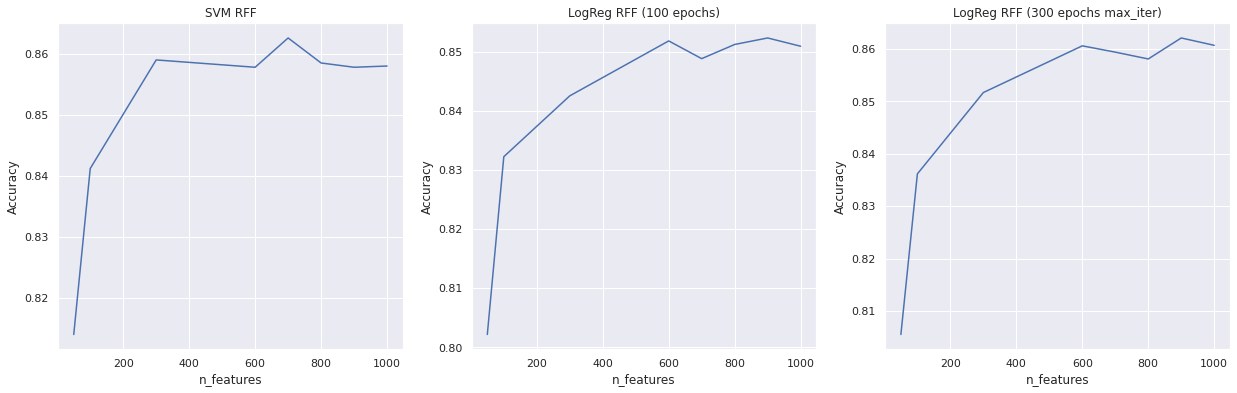

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(21, 6))

ax[0].plot(features, accs)
ax[0].set_xlabel('n_features')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('SVM RFF')

ax[1].plot(features, logreg_accs)
ax[1].set_xlabel('n_features')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('LogReg RFF (100 epochs)')

ax[2].plot(features, logreg_accs300)
ax[2].set_xlabel('n_features')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('LogReg RFF (300 epochs max_iter)')

plt.show()

__Выводы__

Да, действительно, выходит на плато в обоих видах моделей. 

Если ждать окончательной сходимости, то в логрег можно получать 0.875, но это так долго, что лучше использовать нейронки (может быть, надо тестить). При одинаковых затратах по времени логрес и метод опорных векторов отработали с сопоставимым качеством.